### Common Pandas Operations

We will use the data set from NYC OpenData called "New York City Leading Causes of Death".

In [1]:
%matplotlib inline
import requests
import pandas as pd
import numpy as np

#### Fetching the data


We fetch the data in JSON format using the NYC OpenData API:

In [29]:
# Data set: New York City Leading Causes of Death
# https://data.cityofnewyork.us/Health/New-York-City-Leading-Causes-of-Death/jb7j-dtam
url = 'http://data.cityofnewyork.us/api/views/jb7j-dtam/rows.json'
results = requests.get(url).json()

In [30]:
results.keys()

dict_keys(['meta', 'data'])

There are two main fields in the returned JSON. The `meta` part that describes the metadata, and the actual `data`.

In [31]:
results['meta']['view'].keys()

dict_keys(['id', 'name', 'assetType', 'attribution', 'averageRating', 'category', 'createdAt', 'description', 'displayType', 'downloadCount', 'hideFromCatalog', 'hideFromDataJson', 'indexUpdatedAt', 'newBackend', 'numberOfComments', 'oid', 'provenance', 'publicationAppendEnabled', 'publicationDate', 'publicationGroup', 'publicationStage', 'rowClass', 'rowsUpdatedAt', 'rowsUpdatedBy', 'tableId', 'totalTimesRated', 'viewCount', 'viewLastModified', 'viewType', 'approvals', 'columns', 'grants', 'metadata', 'owner', 'query', 'rights', 'tableAuthor', 'tags', 'flags'])

In [32]:
results['data']

[['row-93mt-ky3r.6kxv',
  '00000000-0000-0000-103F-3C178E0BD740',
  0,
  1575924582,
  None,
  1575924582,
  None,
  '{ }',
  '2010',
  'Influenza (Flu) and Pneumonia (J09-J18)',
  'F',
  'Hispanic',
  '228',
  '18.7',
  '23.1'],
 ['row-ez7r-gyeg_v47h',
  '00000000-0000-0000-C361-BDE829E08348',
  0,
  1575924582,
  None,
  1575924582,
  None,
  '{ }',
  '2008',
  'Accidents Except Drug Posioning (V01-X39, X43, X45-X59, Y85-Y86)',
  'F',
  'Hispanic',
  '68',
  '5.8',
  '6.6'],
 ['row-gxtp.a5zu-5jeq',
  '00000000-0000-0000-BA35-9CC72516B3BB',
  0,
  1575924582,
  None,
  1575924582,
  None,
  '{ }',
  '2013',
  'Accidents Except Drug Posioning (V01-X39, X43, X45-X59, Y85-Y86)',
  'M',
  'White Non-Hispanic',
  '271',
  '20.1',
  '17.9'],
 ['row-putd-67tu_yvhj',
  '00000000-0000-0000-2614-EEF0C423C73A',
  0,
  1575924582,
  None,
  1575924582,
  None,
  '{ }',
  '2010',
  'Cerebrovascular Disease (Stroke: I60-I69)',
  'M',
  'Hispanic',
  '140',
  '12.3',
  '21.4'],
 ['row-5pxs-df4z_rv6j

### Creating a DataFrame from JSON data

Let's create a pandas dataframe from the `results["data"]` part.

In [33]:
df = pd.DataFrame(results["data"])
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,row-93mt-ky3r.6kxv,00000000-0000-0000-103F-3C178E0BD740,0,1575924582,None,1575924582,None,{ },2010,Influenza (Flu) and Pneumonia (J09-J18),F,Hispanic,228,18.7,23.1
1,row-ez7r-gyeg_v47h,00000000-0000-0000-C361-BDE829E08348,0,1575924582,None,1575924582,None,{ },2008,"Accidents Except Drug Posioning (V01-X39, X43,...",F,Hispanic,68,5.8,6.6
2,row-gxtp.a5zu-5jeq,00000000-0000-0000-BA35-9CC72516B3BB,0,1575924582,None,1575924582,None,{ },2013,"Accidents Except Drug Posioning (V01-X39, X43,...",M,White Non-Hispanic,271,20.1,17.9
3,row-putd-67tu_yvhj,00000000-0000-0000-2614-EEF0C423C73A,0,1575924582,None,1575924582,None,{ },2010,Cerebrovascular Disease (Stroke: I60-I69),M,Hispanic,140,12.3,21.4
4,row-5pxs-df4z_rv6j,00000000-0000-0000-7B5F-8AE17973791B,0,1575924582,None,1575924582,None,{ },2009,"Assault (Homicide: Y87.1, X85-Y09)",M,Black Non-Hispanic,255,30,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089,row-kze6.jaxn-8svd,00000000-0000-0000-C13D-94BAA0012566,0,1575924582,None,1575924582,None,{ },2012,Influenza (Flu) and Pneumonia (J09-J18),F,Not Stated/Unknown,6,.,.
1090,row-pez3-ec8a.yz7b,00000000-0000-0000-6DB4-4398CEF9380C,0,1575924582,None,1575924582,None,{ },2014,"Accidents Except Drug Posioning (V01-X39, X43,...",F,White Non-Hispanic,169,11.9,7.4
1091,row-8k6d_8zun.an5x,00000000-0000-0000-9541-15C63671DE07,0,1575924582,None,1575924582,None,{ },2009,Malignant Neoplasms (Cancer: C00-C97),M,White Non-Hispanic,3236,240.5,205.6
1092,row-khbt.rn36~sdtd,00000000-0000-0000-002C-BBD5721F4D22,0,1575924582,None,1575924582,None,{ },2009,"Intentional Self-Harm (Suicide: X60-X84, Y87.0)",M,White Non-Hispanic,191,14.2,13


### Adding Column Names

Hm, this is kind of ugly without column names...

We need to peek at the "meta" part to find information about the columns.

In [7]:
# This part of the results contains the description and names for the columns
columns = results["meta"]["view"]["columns"]
columns

[{'id': -1,
  'name': 'sid',
  'dataTypeName': 'meta_data',
  'fieldName': ':sid',
  'position': 0,
  'renderTypeName': 'meta_data',
  'format': {},
  'flags': ['hidden']},
 {'id': -1,
  'name': 'id',
  'dataTypeName': 'meta_data',
  'fieldName': ':id',
  'position': 0,
  'renderTypeName': 'meta_data',
  'format': {},
  'flags': ['hidden']},
 {'id': -1,
  'name': 'position',
  'dataTypeName': 'meta_data',
  'fieldName': ':position',
  'position': 0,
  'renderTypeName': 'meta_data',
  'format': {},
  'flags': ['hidden']},
 {'id': -1,
  'name': 'created_at',
  'dataTypeName': 'meta_data',
  'fieldName': ':created_at',
  'position': 0,
  'renderTypeName': 'meta_data',
  'format': {},
  'flags': ['hidden']},
 {'id': -1,
  'name': 'created_meta',
  'dataTypeName': 'meta_data',
  'fieldName': ':created_meta',
  'position': 0,
  'renderTypeName': 'meta_data',
  'format': {},
  'flags': ['hidden']},
 {'id': -1,
  'name': 'updated_at',
  'dataTypeName': 'meta_data',
  'fieldName': ':updated_at'

In [8]:
# We will create a list of the column names, to reuse it when creating our dataframe
headers = [c["fieldName"] for c in columns]
headers

[':sid',
 ':id',
 ':position',
 ':created_at',
 ':created_meta',
 ':updated_at',
 ':updated_meta',
 ':meta',
 'year',
 'leading_cause',
 'sex',
 'race_ethnicity',
 'deaths',
 'death_rate',
 'age_adjusted_death_rate']

In [9]:
# Now we also pass a list of column names
df = pd.DataFrame(results["data"], columns=headers)
df

,:sid,:id,:position,:created_at,:created_meta,:updated_at,:updated_meta,:meta,year,leading_cause,sex,race_ethnicity,deaths,death_rate,age_adjusted_death_rate
0,row-93mt-ky3r.6kxv,00000000-0000-0000-103F-3C178E0BD740,0,1575924582,None,1575924582,None,{ },2010,Influenza (Flu) and Pneumonia (J09-J18),F,Hispanic,228,18.7,23.1
1,row-ez7r-gyeg_v47h,00000000-0000-0000-C361-BDE829E08348,0,1575924582,None,1575924582,None,{ },2008,"Accidents Except Drug Posioning (V01-X39, X43,...",F,Hispanic,68,5.8,6.6
2,row-gxtp.a5zu-5jeq,00000000-0000-0000-BA35-9CC72516B3BB,0,1575924582,None,1575924582,None,{ },2013,"Accidents Except Drug Posioning (V01-X39, X43,...",M,White Non-Hispanic,271,20.1,17.9
3,row-putd-67tu_yvhj,00000000-0000-0000-2614-EEF0C423C73A,0,1575924582,None,1575924582,None,{ },2010,Cerebrovascular Disease (Stroke: I60-I69),M,Hispanic,140,12.3,21.4
4,row-5pxs-df4z_rv6j,00000000-0000-0000-7B5F-8AE17973791B,0,1575924582,None,1575924582,None,{ },2009,"Assault (Homicide: Y87.1, X85-Y09)",M,Black Non-Hispanic,255,30,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089,row-kze6.jaxn-8svd,00000000-0000-0000-C13D-94BAA0012566,0,1575924582,None,1575924582,None,{ },2012,Influenza (Flu) and Pneumonia (J09-J18),F,Not Stated/Unknown,6,.,.
1090,row-pez3-ec8a.yz7b,00000000-0000-0000-6DB4-4398CEF9380C,0,1575924582,None,1575924582,None,{ },2014,"Accidents Except Drug Posioning (V01-X39, X43,...",F,White Non-Hispanic,169,11.9,7.4
1091,row-8k6d_8zun.an5x,00000000-0000-0000-9541-15C63671DE07,0,1575924582,None,1575924582,None,{ },2009,Malignant Neoplasms (Cancer: C00-C97),M,White Non-Hispanic,3236,240.5,205.6
1092,row-khbt.rn36~sdtd,00000000-0000-0000-002C-BBD5721F4D22,0,1575924582,None,1575924582,None,{ },2009,"Intentional Self-Harm (Suicide: X60-X84, Y87.0)",M,White Non-Hispanic,191,14.2,13


### Deleting Columns and/or Rows

We do not need all these columns. Let's drop a few that we will definitely not use. For that, we will use the `drop` command

In [10]:
df.drop(labels = [':sid', ':position', ':meta', ':created_meta', ':updated_meta'], 
        axis='columns', inplace=True)
df

,:id,:created_at,:updated_at,year,leading_cause,sex,race_ethnicity,deaths,death_rate,age_adjusted_death_rate
0,00000000-0000-0000-103F-3C178E0BD740,1575924582,1575924582,2010,Influenza (Flu) and Pneumonia (J09-J18),F,Hispanic,228,18.7,23.1
1,00000000-0000-0000-C361-BDE829E08348,1575924582,1575924582,2008,"Accidents Except Drug Posioning (V01-X39, X43,...",F,Hispanic,68,5.8,6.6
2,00000000-0000-0000-BA35-9CC72516B3BB,1575924582,1575924582,2013,"Accidents Except Drug Posioning (V01-X39, X43,...",M,White Non-Hispanic,271,20.1,17.9
3,00000000-0000-0000-2614-EEF0C423C73A,1575924582,1575924582,2010,Cerebrovascular Disease (Stroke: I60-I69),M,Hispanic,140,12.3,21.4
4,00000000-0000-0000-7B5F-8AE17973791B,1575924582,1575924582,2009,"Assault (Homicide: Y87.1, X85-Y09)",M,Black Non-Hispanic,255,30,30
...,...,...,...,...,...,...,...,...,...,...
1089,00000000-0000-0000-C13D-94BAA0012566,1575924582,1575924582,2012,Influenza (Flu) and Pneumonia (J09-J18),F,Not Stated/Unknown,6,.,.
1090,00000000-0000-0000-6DB4-4398CEF9380C,1575924582,1575924582,2014,"Accidents Except Drug Posioning (V01-X39, X43,...",F,White Non-Hispanic,169,11.9,7.4
1091,00000000-0000-0000-9541-15C63671DE07,1575924582,1575924582,2009,Malignant Neoplasms (Cancer: C00-C97),M,White Non-Hispanic,3236,240.5,205.6
1092,00000000-0000-0000-002C-BBD5721F4D22,1575924582,1575924582,2009,"Intentional Self-Harm (Suicide: X60-X84, Y87.0)",M,White Non-Hispanic,191,14.2,13


##### Common Patterns: axis and inplace

* The `axis='columns'` says that we are looking to drop columns. If we had `axis='index'` we would be dropping rows with the passed id's. The ids for the row is the index value for the row.

* The `inplace=True` specifies that we will not be creating a new dataframe, but we just replace the current one, with the new dataframe that has fewer columns.

In [11]:
df

,:id,:created_at,:updated_at,year,leading_cause,sex,race_ethnicity,deaths,death_rate,age_adjusted_death_rate
0,00000000-0000-0000-103F-3C178E0BD740,1575924582,1575924582,2010,Influenza (Flu) and Pneumonia (J09-J18),F,Hispanic,228,18.7,23.1
1,00000000-0000-0000-C361-BDE829E08348,1575924582,1575924582,2008,"Accidents Except Drug Posioning (V01-X39, X43,...",F,Hispanic,68,5.8,6.6
2,00000000-0000-0000-BA35-9CC72516B3BB,1575924582,1575924582,2013,"Accidents Except Drug Posioning (V01-X39, X43,...",M,White Non-Hispanic,271,20.1,17.9
3,00000000-0000-0000-2614-EEF0C423C73A,1575924582,1575924582,2010,Cerebrovascular Disease (Stroke: I60-I69),M,Hispanic,140,12.3,21.4
4,00000000-0000-0000-7B5F-8AE17973791B,1575924582,1575924582,2009,"Assault (Homicide: Y87.1, X85-Y09)",M,Black Non-Hispanic,255,30,30
...,...,...,...,...,...,...,...,...,...,...
1089,00000000-0000-0000-C13D-94BAA0012566,1575924582,1575924582,2012,Influenza (Flu) and Pneumonia (J09-J18),F,Not Stated/Unknown,6,.,.
1090,00000000-0000-0000-6DB4-4398CEF9380C,1575924582,1575924582,2014,"Accidents Except Drug Posioning (V01-X39, X43,...",F,White Non-Hispanic,169,11.9,7.4
1091,00000000-0000-0000-9541-15C63671DE07,1575924582,1575924582,2009,Malignant Neoplasms (Cancer: C00-C97),M,White Non-Hispanic,3236,240.5,205.6
1092,00000000-0000-0000-002C-BBD5721F4D22,1575924582,1575924582,2009,"Intentional Self-Harm (Suicide: X60-X84, Y87.0)",M,White Non-Hispanic,191,14.2,13


### Renaming Columns

We do not like some of these column names. Let's rename them.

We will use a dictionary, for specifying the existing and the new names for the columns.

In [12]:
# This dictionary specifies as a key the existing name of the column, and as value the new name
renaming_dict = {
    ':id': 'key', 
    ':created_at': 'created_at', 
    ':updated_at': 'updated_at'
}

df.rename(columns=renaming_dict, inplace=True)
df

,key,created_at,updated_at,year,leading_cause,sex,race_ethnicity,deaths,death_rate,age_adjusted_death_rate
0,00000000-0000-0000-103F-3C178E0BD740,1575924582,1575924582,2010,Influenza (Flu) and Pneumonia (J09-J18),F,Hispanic,228,18.7,23.1
1,00000000-0000-0000-C361-BDE829E08348,1575924582,1575924582,2008,"Accidents Except Drug Posioning (V01-X39, X43,...",F,Hispanic,68,5.8,6.6
2,00000000-0000-0000-BA35-9CC72516B3BB,1575924582,1575924582,2013,"Accidents Except Drug Posioning (V01-X39, X43,...",M,White Non-Hispanic,271,20.1,17.9
3,00000000-0000-0000-2614-EEF0C423C73A,1575924582,1575924582,2010,Cerebrovascular Disease (Stroke: I60-I69),M,Hispanic,140,12.3,21.4
4,00000000-0000-0000-7B5F-8AE17973791B,1575924582,1575924582,2009,"Assault (Homicide: Y87.1, X85-Y09)",M,Black Non-Hispanic,255,30,30
...,...,...,...,...,...,...,...,...,...,...
1089,00000000-0000-0000-C13D-94BAA0012566,1575924582,1575924582,2012,Influenza (Flu) and Pneumonia (J09-J18),F,Not Stated/Unknown,6,.,.
1090,00000000-0000-0000-6DB4-4398CEF9380C,1575924582,1575924582,2014,"Accidents Except Drug Posioning (V01-X39, X43,...",F,White Non-Hispanic,169,11.9,7.4
1091,00000000-0000-0000-9541-15C63671DE07,1575924582,1575924582,2009,Malignant Neoplasms (Cancer: C00-C97),M,White Non-Hispanic,3236,240.5,205.6
1092,00000000-0000-0000-002C-BBD5721F4D22,1575924582,1575924582,2009,"Intentional Self-Harm (Suicide: X60-X84, Y87.0)",M,White Non-Hispanic,191,14.2,13


### Converting Data Types

In [13]:
df.dtypes

key                        object
created_at                  int64
updated_at                  int64
year                       object
leading_cause              object
sex                        object
race_ethnicity             object
deaths                     object
death_rate                 object
age_adjusted_death_rate    object
dtype: object

In [14]:
# Let's convert to the right data types the year,count,percent
df["year"] = pd.to_numeric(df["year"])
df.dtypes

key                        object
created_at                  int64
updated_at                  int64
year                        int64
leading_cause              object
sex                        object
race_ethnicity             object
deaths                     object
death_rate                 object
age_adjusted_death_rate    object
dtype: object

Sometimes, during the conversion of data, the cells contain values that cannot be properly converted. We can specify how we want pandas to handle such cases. By default, it will raise an exception, and will not allow us to convert the data to a new data type.

In [15]:
# This one will cause an error, as the "deaths" column contains non-numeric values.
# Try by uncommenting
# df["deaths"] = pd.to_numeric(df["deaths"])

We can pass the `errors` command to specify what should happen. From the [documentation of to_numeric](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_numeric.html), we get:
* If ‘raise’, then invalid parsing will raise an exception
* If ‘coerce’, then invalid parsing will be set as NaN
* If ‘ignore’, then invalid parsing will return the input

In [16]:
df["deaths"] = pd.to_numeric(df["deaths"], errors='coerce')
df["death_rate"] = pd.to_numeric(df["death_rate"], errors='coerce')
df["age_adjusted_death_rate"] = pd.to_numeric(df["age_adjusted_death_rate"], errors='coerce')
df.dtypes

key                         object
created_at                   int64
updated_at                   int64
year                         int64
leading_cause               object
sex                         object
race_ethnicity              object
deaths                     float64
death_rate                 float64
age_adjusted_death_rate    float64
dtype: object

In [17]:
df

,key,created_at,updated_at,year,leading_cause,sex,race_ethnicity,deaths,death_rate,age_adjusted_death_rate
0,00000000-0000-0000-103F-3C178E0BD740,1575924582,1575924582,2010,Influenza (Flu) and Pneumonia (J09-J18),F,Hispanic,228.0,18.7,23.1
1,00000000-0000-0000-C361-BDE829E08348,1575924582,1575924582,2008,"Accidents Except Drug Posioning (V01-X39, X43,...",F,Hispanic,68.0,5.8,6.6
2,00000000-0000-0000-BA35-9CC72516B3BB,1575924582,1575924582,2013,"Accidents Except Drug Posioning (V01-X39, X43,...",M,White Non-Hispanic,271.0,20.1,17.9
3,00000000-0000-0000-2614-EEF0C423C73A,1575924582,1575924582,2010,Cerebrovascular Disease (Stroke: I60-I69),M,Hispanic,140.0,12.3,21.4
4,00000000-0000-0000-7B5F-8AE17973791B,1575924582,1575924582,2009,"Assault (Homicide: Y87.1, X85-Y09)",M,Black Non-Hispanic,255.0,30.0,30.0
...,...,...,...,...,...,...,...,...,...,...
1089,00000000-0000-0000-C13D-94BAA0012566,1575924582,1575924582,2012,Influenza (Flu) and Pneumonia (J09-J18),F,Not Stated/Unknown,6.0,NaN,NaN
1090,00000000-0000-0000-6DB4-4398CEF9380C,1575924582,1575924582,2014,"Accidents Except Drug Posioning (V01-X39, X43,...",F,White Non-Hispanic,169.0,11.9,7.4
1091,00000000-0000-0000-9541-15C63671DE07,1575924582,1575924582,2009,Malignant Neoplasms (Cancer: C00-C97),M,White Non-Hispanic,3236.0,240.5,205.6
1092,00000000-0000-0000-002C-BBD5721F4D22,1575924582,1575924582,2009,"Intentional Self-Harm (Suicide: X60-X84, Y87.0)",M,White Non-Hispanic,191.0,14.2,13.0


We will also mark the other values as Categorical.

In [18]:
df["sex"] = pd.Categorical(df["sex"])
df["race_ethnicity"] = pd.Categorical(df["race_ethnicity"])
df["leading_cause"] = pd.Categorical(df["leading_cause"])
df.dtypes

key                          object
created_at                    int64
updated_at                    int64
year                          int64
leading_cause              category
sex                        category
race_ethnicity             category
deaths                      float64
death_rate                  float64
age_adjusted_death_rate     float64
dtype: object

And we will also convert the timestamps to dates. Notice that we specify the unit to be `s` which is seconds since 1970.

In [19]:
df["created_at"] = pd.to_datetime(df["created_at"], unit='s')
df["updated_at"] = pd.to_datetime(df["updated_at"], unit='s')
df.dtypes

key                                object
created_at                 datetime64[ns]
updated_at                 datetime64[ns]
year                                int64
leading_cause                    category
sex                              category
race_ethnicity                   category
deaths                            float64
death_rate                        float64
age_adjusted_death_rate           float64
dtype: object

In [26]:
df.sort_values('year')

,key,created_at,updated_at,year,leading_cause,sex,race_ethnicity,deaths,death_rate,age_adjusted_death_rate
618,00000000-0000-0000-E7F0-A8F3DD5343ED,2019-12-09 20:49:42,2019-12-09 20:49:42,2007,All Other Causes,F,Not Stated/Unknown,27.0,NaN,NaN
576,00000000-0000-0000-6018-C8A2020C29F7,2019-12-09 20:49:42,2019-12-09 20:49:42,2007,All Other Causes,F,Other Race/ Ethnicity,15.0,NaN,NaN
340,00000000-0000-0000-B835-BCFF24D2F690,2019-12-09 20:49:42,2019-12-09 20:49:42,2007,All Other Causes,M,Hispanic,988.0,90.6,142.6
108,00000000-0000-0000-5FEE-115A7232E902,2019-12-09 20:49:42,2019-12-09 20:49:42,2007,Mental and Behavioral Disorders due to Acciden...,M,Not Stated/Unknown,10.0,NaN,NaN
110,00000000-0000-0000-39B1-241D901DE814,2019-12-09 20:49:42,2019-12-09 20:49:42,2007,All Other Causes,F,Black Non-Hispanic,1230.0,116.8,113.4
...,...,...,...,...,...,...,...,...,...,...
953,00000000-0000-0000-EC9C-056807463497,2019-12-09 20:49:42,2019-12-09 20:49:42,2014,Diabetes Mellitus (E10-E14),F,White Non-Hispanic,228.0,16.1,10.0
956,00000000-0000-0000-AE3F-30CD82CBF31C,2019-12-09 20:49:42,2019-12-09 20:49:42,2014,"Accidents Except Drug Posioning (V01-X39, X43,...",M,Hispanic,176.0,14.7,16.9
957,00000000-0000-0000-EDC1-984EF4D96ACD,2019-12-09 20:49:42,2019-12-09 20:49:42,2014,"Accidents Except Drug Posioning (V01-X39, X43,...",M,Black Non-Hispanic,148.0,17.1,17.7
944,00000000-0000-0000-60AC-F3A1405749ED,2019-12-09 20:49:42,2019-12-09 20:49:42,2014,All Other Causes,M,Not Stated/Unknown,96.0,NaN,NaN


### Exploratory Data Analysis

In [21]:
df["race_ethnicity"].value_counts()

Not Stated/Unknown            200
Other Race/ Ethnicity         186
Black Non-Hispanic            178
Hispanic                      177
Asian and Pacific Islander    177
White Non-Hispanic            176
Name: race_ethnicity, dtype: int64

In [22]:
df["sex"].value_counts()

F    554
M    540
Name: sex, dtype: int64

In [23]:
df["leading_cause"].value_counts()

Diseases of Heart (I00-I09, I11, I13, I20-I51)                                                                                       96
Malignant Neoplasms (Cancer: C00-C97)                                                                                                96
All Other Causes                                                                                                                     96
Influenza (Flu) and Pneumonia (J09-J18)                                                                                              96
Diabetes Mellitus (E10-E14)                                                                                                          92
Cerebrovascular Disease (Stroke: I60-I69)                                                                                            90
Chronic Lower Respiratory Diseases (J40-J47)                                                                                         88
Accidents Except Drug Posioning (V01-X39, X43, X

### Pivot Tables

Let's create a pivot table now. We are going to put the "leading cause" as the row, with sex and race as columns. For the cell values we will use the number of deaths, and we are going to sum (`np.sum`) the values.

_Note: You will also find the `pivot` and `crosstab` functions in Pandas. The `pivot_table` function is typically a more general version of both._

In [25]:

import numpy as np
pivot = pd.pivot_table(df, 
                       values='deaths', 
                       index=['leading_cause'], # rows
                       columns=['sex', 'race_ethnicity'], # columns
                       aggfunc=np.sum) # aggregation function
pivot

sex                                                                         F  \
race_ethnicity                                     Asian and Pacific Islander   
leading_cause                                                                   
Accidents Except Drug Posioning (V01-X39, X43, ...                      284.0   
All Other Causes                                                       2118.0   
Alzheimer's Disease (G30)                                                64.0   
Aortic Aneurysm and Dissection (I71)                                      NaN   
Assault (Homicide: Y87.1, X85-Y09)                                        NaN   
Atherosclerosis (I70)                                                     NaN   
Cerebrovascular Disease (Stroke: I60-I69)                               677.0   
Certain Conditions originating in the Perinatal...                       18.0   
Chronic Liver Disease and Cirrhosis (K70, K73)                            NaN   
Chronic Lower Respiratory Diseases (J40-J47)                            249.0   
Congenital Malformations, Deformations, and Chr...                        NaN   
Diabetes Mellitus (E10-E14)                                             405.0   
Diseases of Heart (I00-I09, I11, I13, I20-I51)                         3429.0   
Essential Hypertension and Renal Diseases (I10,...                      269.0   
Human Immunodeficiency Virus Disease (HIV: B20-...                        NaN   
Influenza (Flu) and Pneumonia (J09-J18)                                 603.0   
Insitu or Benign / Uncertain Neoplasms (D00-D48)                          NaN   
Intentional Self-Harm (Suicide: X60-X84, Y87.0)                         164.0   
Malignant Neoplasms (Cancer: C00-C97)                                  3432.0   
Mental and Behavioral Disorders due to Accident...                        NaN   
Mental and Behavioral Disorders due to Use of A...                        NaN   
Nephritis, Nephrotic Syndrome and Nephrisis (N0...                       48.0   
Parkinson's Disease (G20)                                                 NaN   
Septicemia (A40-A41)                                                     16.0   
Tuberculosis (A16-A19)                                                    NaN   
Viral Hepatitis (B15-B19)                                                15.0   

sex                                                                    \
race_ethnicity                                     Black Non-Hispanic   
leading_cause                                                           
Accidents Except Drug Posioning (V01-X39, X43, ...              157.0   
All Other Causes                                              11178.0   
Alzheimer's Disease (G30)                                       601.0   
Aortic Aneurysm and Dissection (I71)                              NaN   
Assault (Homicide: Y87.1, X85-Y09)                                NaN   
Atherosclerosis (I70)                                             NaN   
Cerebrovascular Disease (Stroke: I60-I69)                      2147.0   
Certain Conditions originating in the Perinatal...                NaN   
Chronic Liver Disease and Cirrhosis (K70, K73)                    NaN   
Chronic Lower Respiratory Diseases (J40-J47)                   1651.0   
Congenital Malformations, Deformations, and Chr...                NaN   
Diabetes Mellitus (E10-E14)                                    3133.0   
Diseases of Heart (I00-I09, I11, I13, I20-I51)                19335.0   
Essential Hypertension and Renal Diseases (I10,...             1723.0   
Human Immunodeficiency Virus Disease (HIV: B20-...             1324.0   
Influenza (Flu) and Pneumonia (J09-J18)                        2288.0   
Insitu or Benign / Uncertain Neoplasms (D00-D48)                  NaN   
Intentional Self-Harm (Suicide: X60-X84, Y87.0)                   NaN   
Malignant Neoplasms (Cancer: C00-C97)                         14525.0   
Mental and Behavioral Disorders due to Accid

And we can easily transpose the dataframe

In [34]:
pivot.transpose()
# alternatively
# pivot.T

leading_cause                   Accidents Except Drug Posioning (V01-X39, X43, X45-X59, Y85-Y86)  \
sex race_ethnicity                                                                                 
F   Asian and Pacific Islander                                              284.0                  
    Black Non-Hispanic                                                      157.0                  
    Hispanic                                                                437.0                  
    Not Stated/Unknown                                                        0.0                  
    Other Race/ Ethnicity                                                     6.0                  
    White Non-Hispanic                                                     1392.0                  
M   Asian and Pacific Islander                                              463.0                  
    Black Non-Hispanic                                                     1044.0                  
    Hispanic                                                               1378.0                  
    Not Stated/Unknown                                                       58.0                  
    Other Race/ Ethnicity                                                    42.0                  
    White Non-Hispanic                                                     2206.0                  

leading_cause                   All Other Causes  Alzheimer's Disease (G30)  \
sex race_ethnicity                                                            
F   Asian and Pacific Islander            2118.0                       64.0   
    Black Non-Hispanic                   11178.0                      601.0   
    Hispanic                              7838.0                      605.0   
    Not Stated/Unknown                     307.0                        8.0   
    Other Race/ Ethnicity                  230.0                        0.0   
    White Non-Hispanic                   17272.0                     1702.0   
M   Asian and Pacific Islander            2479.0                        NaN   
    Black Non-Hispanic                   10228.0                        NaN   
    Hispanic                              9085.0                        NaN   
    Not Stated/Unknown                     548.0                        NaN   
    Other Race/ Ethnicity                  242.0                        0.0   
    White Non-Hispanic                   16474.0                        NaN   

leading_cause                   Aortic Aneurysm and Dissection (I71)  \
sex race_ethnicity                                                     
F   Asian and Pacific Islander                                   NaN   
    Black Non-Hispanic                                           NaN   
    Hispanic                                                     NaN   
    Not Stated/Unknown                                           0.0   
    Other Race/ Ethnicity                                        0.0   
    White Non-Hispanic                                           NaN   
M   Asian and Pacific Islander                                   NaN   
    Black Non-Hispanic                                           NaN   
    Hispanic                                                     NaN   
    Not Stated/Unknown                                           NaN   
    Other Race/ Ethnicity                                        0.0   
    White Non-Hispanic                                           NaN   

leading_cause                   Assault (Homicide: Y87.1, X85-Y09)  \
sex race_ethnicity                                                   
F   Asian and Pacific Islander                                 NaN   
    Black Non-Hispanic                                         NaN   
    Hispanic                                                   NaN   
    Not Stated/Unknown                                         0.0   
    Other Race/ Ethnicity                                      

<AxesSubplot:xlabel='sex,race_ethnicity'>

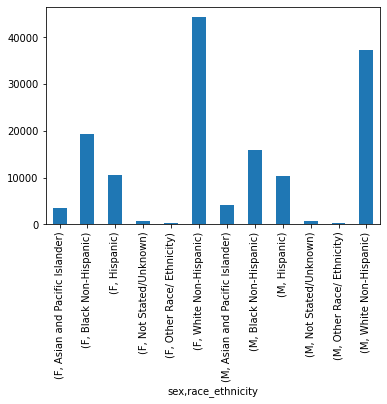

In [35]:
# And we can of course, plot:
pivot.transpose()["Diseases of Heart (I00-I09, I11, I13, I20-I51)"].plot.bar()

#### Exercises

* Write a function that will change the values for the "leading cause" column, and make them shorter. For example, we want to eliminate the codes within the parentheses; the value "Alzheimer's Disease (G30)" should become "Alzheimer's Disease". Use the `apply` function and/or the `map` function to create a new column with the shortened values. Then use the `drop` command to delete the old `leading_cause` column. 
* Change the pivot_table to compute the average `age_adjusted_death_rate` instead of the sum of deaths. (Hint: you can use the `numpy.mean` function to compute averages.

In [ ]:
# Example input: 
# 'Accidents Except Drug Posioning (V01-X39, X43, X45-X59, Y85-Y86)
# Example output
# 'Accidents Except Drug Posioning'
import re

def shorten(cause):
    # Get everything before the parentheses
    regex_expression = r'(.*)\(.*\)' # notice that we escape the parentheses
    regex= re.compile(regex_expression)
    matches = regex.finditer(cause)
    for m in matches:
        return m.group(1).strip()[:30]
    return cause[:30]

shorten('Accidents Except Drug Posioning (V01-X39, X43, X45-X59, Y85-Y86)')

In [ ]:
[shorten(cause) for cause in set(df['leading_cause'].values)]

In [ ]:
df["cause"] = df["leading_cause"].apply(shorten)
df

In [ ]:

import numpy as np
pivot = pd.pivot_table(df, 
                       values='deaths', 
                       index=['cause'], # rows
                       columns=['sex', 'race_ethnicity'], # columns
                       aggfunc=np.mean) # aggregation function
pivot

#### Exercise

* Get a new dataset from NYC Open Data. (Go for something small.) Fetch it and load it into a dataframe. Put the right column names into the dataframe, eliminate columns and rows that you do not need. Create a basic plot that summarizes some aspect of the dataset.